In [1]:
import pandas as pd
import numpy as np

In [65]:
csv_path = '/content/drive/MyDrive/voltron/content/labelled_dataset.csv'
model_path = '/content/drive/MyDrive/voltron/content/'
df = pd.read_csv(csv_path)
df = df[5::4]
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head()


,ts,co2,humidity,pm10,pm25,temperature,temperature_label,humidity_label,pm25_label,pm10_label,co2_label,ISO5
5,2016-11-21 00:52:03,355.000000,62.617500,1.332509,0.385662,21.66,True,True,True,True,True,True
9,2016-11-21 00:56:03,355.500000,61.691667,1.369232,0.400478,22.16,True,True,True,True,True,True
13,2016-11-21 01:00:03,356.166667,60.426667,1.375061,0.328504,22.61,True,True,True,True,True,True
17,2016-11-21 01:04:03,356.500000,59.464167,1.270852,0.562119,22.88,True,True,False,True,True,False
21,2016-11-21 01:08:03,357.666667,58.520000,1.270852,0.616186,23.21,True,True,False,True,True,False


In [66]:
df.count()

ts                   33774
co2                  33774
humidity             33774
pm10                 33774
pm25                 33774
temperature          33774
temperature_label    33774
humidity_label       33774
pm25_label           33774
pm10_label           33774
co2_label            33774
ISO5                 33774
dtype: int64

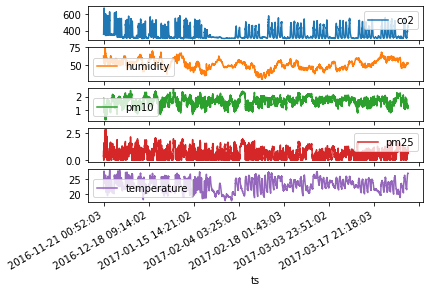

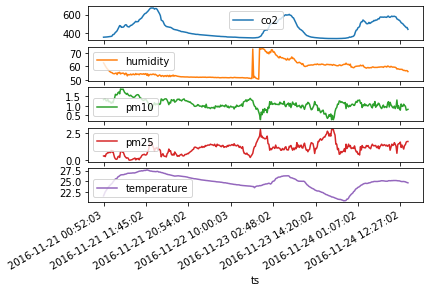

In [67]:

plot_cols = ['ts', 'co2','humidity', 'pm10', 'pm25', "temperature"]
plot_features = df[plot_cols]
plot_features.index = df["ts"]
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:360]
plot_features.index = date_time[:360]
_ = plot_features.plot(subplots=True)

In [68]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
co2,33774.0,354.815869,64.319737,301.500000,311.500000,320.500000,382.000000,672.166667
humidity,33774.0,50.373521,6.759726,29.360000,45.986667,50.186667,54.920000,73.226667
pm10,33774.0,1.638432,0.311495,0.278151,1.424279,1.646128,1.869216,2.561829
pm25,33774.0,0.627497,0.447564,0.000000,0.248461,0.548121,0.941609,2.813411
temperature,33774.0,22.939741,2.051124,17.710000,21.410000,22.860000,24.650000,27.960000


co2
humidity
pm10
pm25
temperature
temperature_label


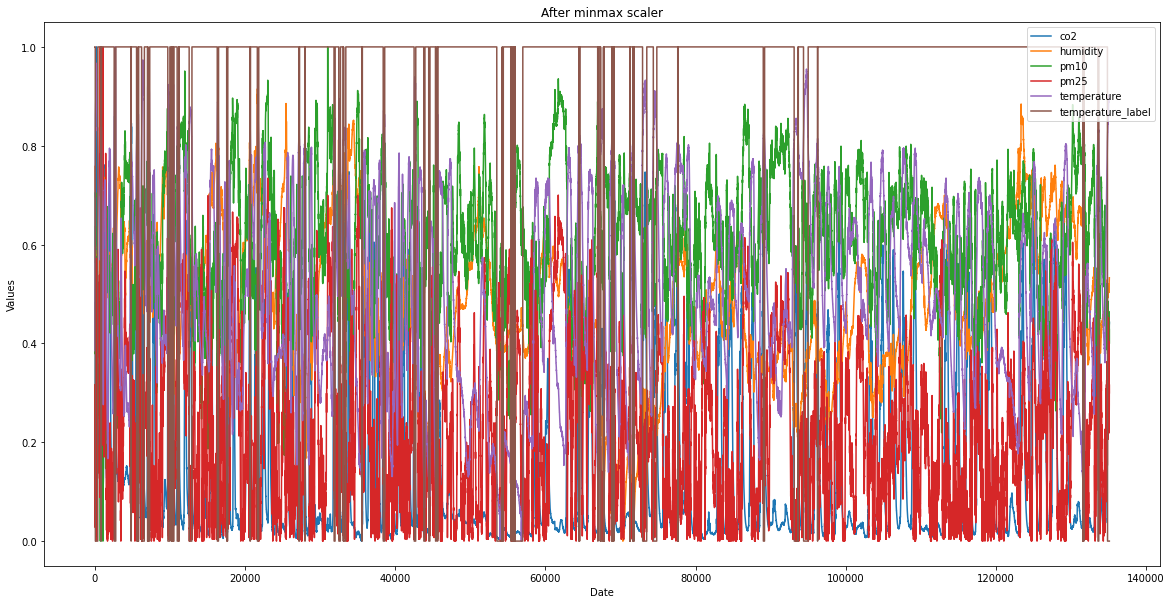

In [75]:
import sklearn
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['temperature'] = min_max_scaler.fit_transform(df.temperature.values.reshape(-1,1))
    df['humidity'] = min_max_scaler.fit_transform(df.humidity.values.reshape(-1,1))
    df['co2'] = min_max_scaler.fit_transform(df.co2.values.reshape(-1,1))
    df['pm25'] = min_max_scaler.fit_transform(df.pm25.values.reshape(-1,1))
    df['pm10'] = min_max_scaler.fit_transform(df.pm10.values.reshape(-1,1))
    return df

normalized = normalize_data(df)
plot_all(normalized, title='After minmax scaler')

co2
humidity
pm10
pm25
temperature
temperature_label


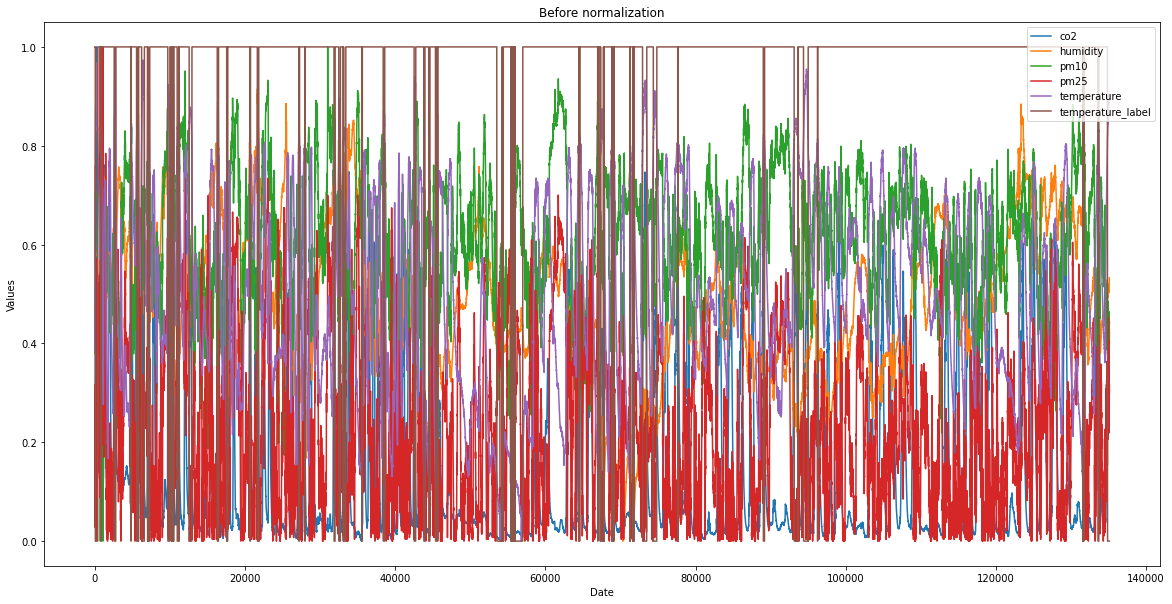

In [76]:
import matplotlib.pyplot as plt

def plot_all(df, title='Data', xlabel='Date', ylabel='Values'):
    plt.figure(figsize=(20,10))
    for col in df.columns[1:7]:
        print(col)
        plt.plot(df[col].sort_index())
    plt.legend(df.columns[1:7])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
plot_all(df, title='Before normalization')

In [80]:
PM1 = 3
PM25 = 4
PM10 = 5

def prepare_batch(train_x, train_y,batch_size, i):
    batch_x, batch_y = (train_x[:, :, i*batch_size:(i+1)*batch_size], train_y[:, i*batch_size:(i+1)*batch_size])
    print(batch_y.shape)
    print(batch_x.shape)
    batch_x = batch_x.reshape(batch_x.shape[2], batch_x.shape[0], batch_x.shape[1])
    batch_y = batch_y.reshape(batch_y.shape[0], batch_y.shape[1])
    return batch_x, batch_y

def prepare_data(df, ratio=0.8):
    for day in df.ts.unique():
        daily_data = df[df.ts==day]
        daily_numpy = daily_data.iloc[:, 1:7].values
        if day == df.ts.unique()[0]:
            data = daily_numpy
        else:
            try:
                data = np.dstack([data, daily_numpy])
            except ValueError:
                print('Day {} does not match'.format(day))
    div = round(data.shape[2] * ratio)
    train = data[:, :, :div]
    test = data[:, :, div+1:]
    return train[:, :3, :], train[:, PM25, :], test[:, :3, :], test[:, PM25, :], div

train_x, train_y, test_x, test_y, div = prepare_data(normalized)

(1, 3, 27019) (1, 27019) (1, 3, 6754) (1, 6754)


In [81]:
train_Y = train_y.reshape(train_y.size)
test_Y = test_y.reshape(test_y.size)
train_X = train_x.transpose(0, 2, 1)
train_X = train_X.reshape(train_X.shape[0]*train_X.shape[1], 1, train_X.shape[2])
test_X = test_x.transpose(0, 2, 1)
test_X = test_X.reshape(test_X.shape[0]*test_X.shape[1], 1, test_X.shape[2])

train_X.shape, train_Y.shape, test_X.shape, test_Y.shape

((27019, 1, 3), (27019,), (6754, 1, 3), (6754,))

In [144]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), batch_input_shape=(1, train_X.shape[1], train_X.shape[2]), return_sequences=True, stateful=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(15))
model.compile(loss='mae', optimizer='adam', metrics=['mae', 'acc'])
X_train=np.asarray(train_X).astype(np.int)

y_train=np.asarray(train_Y).astype(np.int)
X_test=np.asarray(test_X).astype(np.int)
Y_test=np.asarray(test_Y).astype(np.int)
print(model.summary())
history = model.fit(X_train, y_train, epochs=30, batch_size=50, validation_data=(X_test, Y_test), verbose=2, shuffle=False)

model.save(model_path)

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_80 (LSTM)               (1, 1, 50)                10800     
_________________________________________________________________
lstm_81 (LSTM)               (1, 50)                   20200     
_________________________________________________________________
dense_39 (Dense)             (1, 15)                   765       
Total params: 31,765
Trainable params: 31,765
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
541/541 - 6s - loss: 2.6166e-04 - mae: 2.6166e-04 - acc: 0.1517 - val_loss: 1.9757e-04 - val_mae: 1.9757e-04 - val_acc: 0.0000e+00
Epoch 2/30
541/541 - 2s - loss: 2.0237e-04 - mae: 2.0237e-04 - acc: 0.0037 - val_loss: 1.2822e-04 - val_mae: 1.2822e-04 - val_acc: 0.0000e+00
Epoch 3/30
541/541 - 1s - loss: 1.8152e-04 - mae: 1.8152e-04 - acc: 0.0259 - val_loss: 1.2

INFO:tensorflow:Assets written to: /content/drive/MyDrive/voltron/content/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/voltron/content/assets


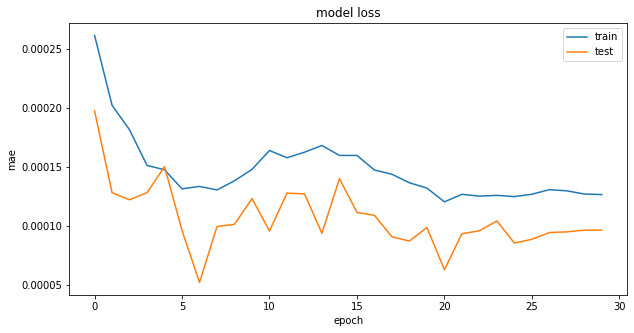

In [145]:

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()